In [19]:
import matplotlib.pyplot as plt
import re

# filenames = ["calm.txt", "2.txt", "3.txt", "4.txt", "5.txt"]
filenames = ["data\k20_11_1.txt"]
file_name = filenames[0]

<>:5: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
C:\Users\phel\AppData\Local\Temp\ipykernel_11964\3848948830.py:5: SyntaxWarning: invalid escape sequence '\k'
  filenames = ["data\k20_11_1.txt"]


In [26]:
ch1, ch2, ch3 = [], [], []

with open(file_name, "r") as file:
    for line in file:
        # match = re.search(r">CH1:(\d+),CH2:(\d+),CH3:(\d+)", line)
        match = re.search(r"EMG_RAW=(\d+), EMG_FILT=(\d+)", line)
        if match:
            ch1.append(int(match.group(1)))
            ch2.append(int(match.group(2)))
            # ch3.append(int(match.group(3)))
            # ch4.append(int(match.group(4)))

time = [i / 100000 for i in range(len(ch1))]



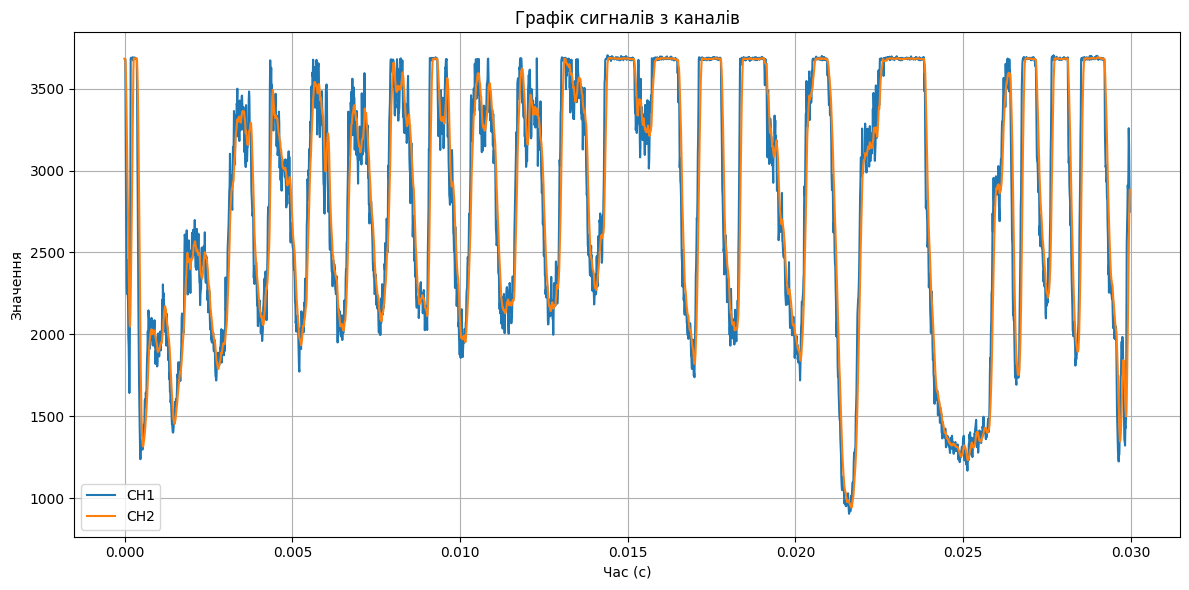

In [27]:
plt.figure(figsize=(12, 6))


plt.plot(time, ch1, label="CH1")
plt.plot(time, ch2, label="CH2")
# plt.plot(time, ch3, label="CH3")
#plt.plot(time, ch4, label="CH4")


plt.title("Графік сигналів з каналів")
plt.xlabel("Час (с)")
plt.ylabel("Значення")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
import numpy as np

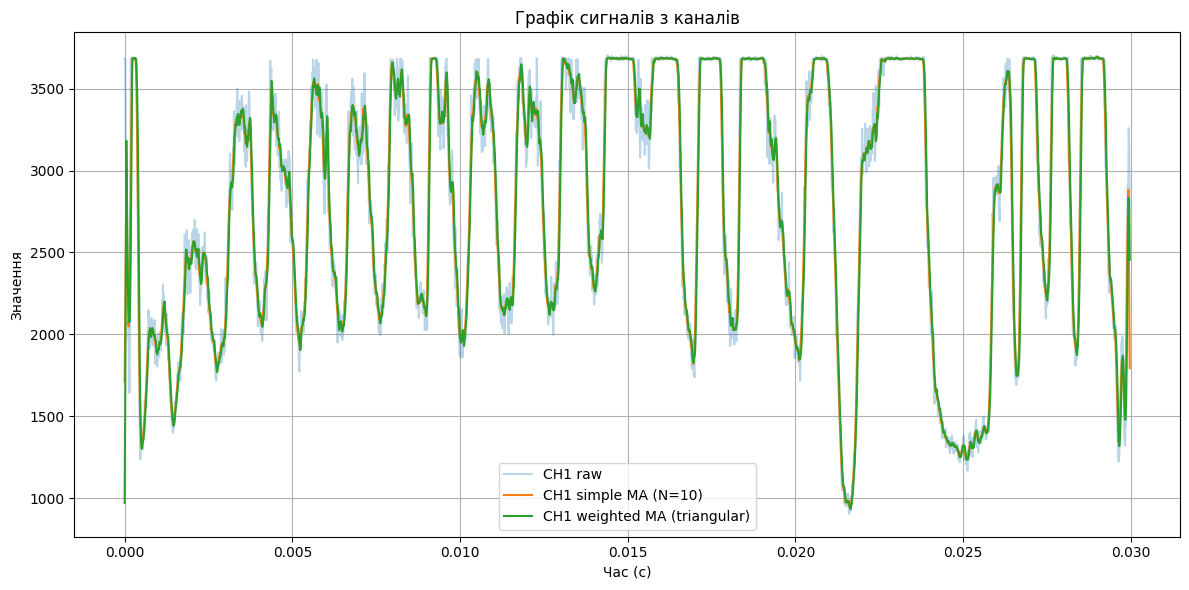

In [28]:
ch1_arr = np.array(ch1)

# ---- просте середнє ----
window_size = 10
kernel_ma = np.ones(window_size) / window_size
ch1_ma = np.convolve(ch1_arr, kernel_ma, mode="same")

# ---- зважене (трикутне) середнє ----
w = np.arange(1, window_size + 1, dtype=float)  # [1, 2, ..., 100]
kernel_w = w / w.sum()                          # нормалізація
ch1_wma = np.convolve(ch1_arr, kernel_w, mode="same")

plt.figure(figsize=(12, 6))
plt.plot(time, ch1_arr, label="CH1 raw", alpha=0.3)
plt.plot(time, ch1_ma, label=f"CH1 simple MA (N={window_size})")
plt.plot(time, ch1_wma, label=f"CH1 weighted MA (triangular)")
plt.xlabel("Час (с)")
plt.ylabel("Значення")
plt.title("Графік сигналів з каналів")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

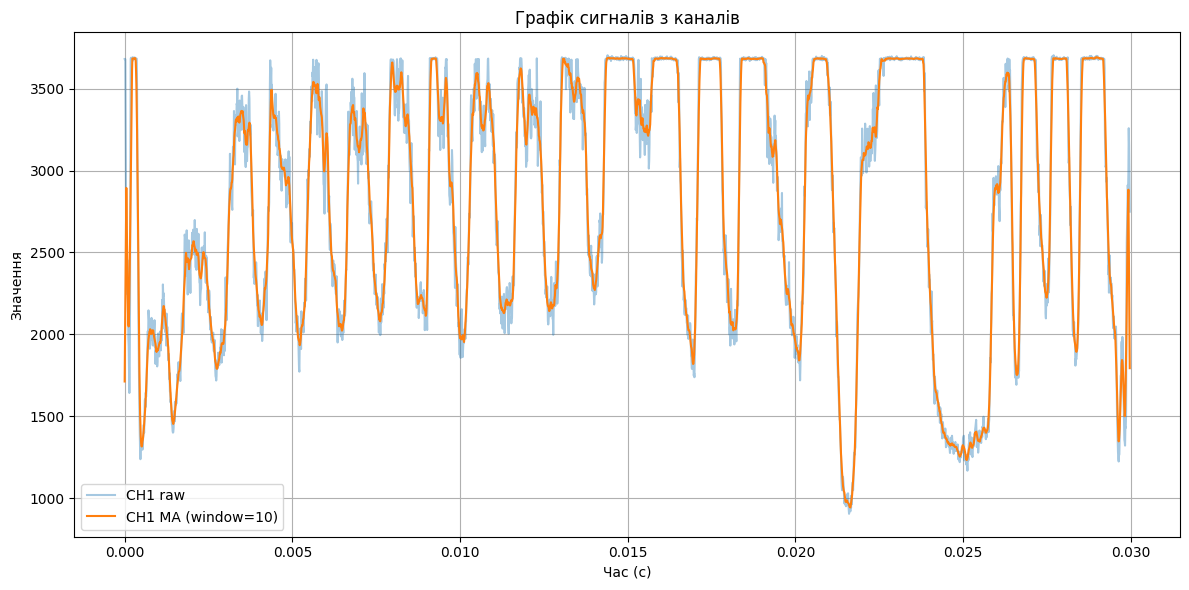

In [29]:
window_size = 10  # розмір вікна у семплах (пограйся 20 / 50 / 100)
kernel = np.ones(window_size) / window_size

ch1_arr = np.array(ch1)
ch1_ma = np.convolve(ch1_arr, kernel, mode="same")  # згладжений сигнал


plt.figure(figsize=(12, 6))

# сирий сигнал (блідіший)
plt.plot(time, ch1_arr, label="CH1 raw", alpha=0.4)

# згладжений сигнал
plt.plot(time, ch1_ma, label=f"CH1 MA (window={window_size})")

plt.title("Графік сигналів з каналів")
plt.xlabel("Час (с)")
plt.ylabel("Значення")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()